In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from epilink import (
    TOIT,
    TOST,
    InfectiousnessParams,
    genetic_linkage_probability,
    pairwise_linkage_probability_matrix,
    presymptomatic_fraction,
    temporal_linkage_probability,
)

sns.set_theme(context="paper", style="white", font_scale=1.2)

## Reproducing [Hart et al. (2021)](https://doi.org/10.7554/eLife.65534) results using fitted parameters (defaults)

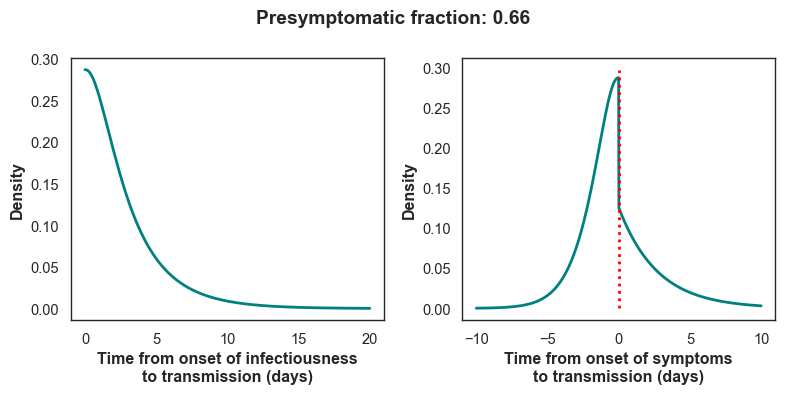

In [2]:
params = InfectiousnessParams(
    k_inc=5.807,
    scale_inc=0.948,
    k_E=3.38,
    mu=0.37,
    k_I=1,
    alpha=2.29
)

toit = TOIT(params=params)
tost = TOST(params=params)

pre_sym_frac = presymptomatic_fraction(params)

num_samples = 1000

tost_values = np.linspace(-10, 10, num_samples)
tost_pdf = tost.pdf(tost_values)

toit_values = np.linspace(0, 20, num_samples)
toit_pdf = toit.pdf(toit_values)

fig1, axes1 = plt.subplots(1, 2, figsize=(8, 4))

sns.lineplot(x=toit_values, y=toit_pdf, color="teal", ax=axes1[0], linewidth=2)
axes1[0].set_xlabel("Time from onset of infectiousness\nto transmission (days)", fontweight="bold")
axes1[0].set_ylabel("Density", fontweight="bold")

sns.lineplot(x=tost_values, y=tost_pdf, color="teal", ax=axes1[1], linewidth=2)
axes1[1].set_xlabel("Time from onset of symptoms\nto transmission (days)", fontweight="bold")
axes1[1].set_ylabel("Density", fontweight="bold")
axes1[1].vlines(0, ymin=0, ymax=max(tost_pdf) + 0.01, color="red", linestyle=":", linewidth=2)

plt.suptitle(f"Presymptomatic fraction: {pre_sym_frac:.2f}", fontweight="bold")

plt.tight_layout()
plt.show()

In [31]:
def plot_intermediate_probabilities(
        genetic_probabilities,
        cmap_name="viridis",
        figsize=(10, 5),
        linewidth=2):

    plt.figure(figsize=figsize)

    x = np.arange(genetic_probabilities.shape[0])  # SNP distance axis
    n_intermediates = genetic_probabilities.shape[1]

    cmap = plt.get_cmap(cmap_name)
    colours = cmap(np.linspace(0, 1, n_intermediates))

    for i in range(n_intermediates):
        plt.plot(
            x,
            genetic_probabilities[:, i],
            color=colours[i],
            linewidth=linewidth,
            label=f"Intermediate {i}",
            marker="o",

        )

    plt.xlabel("Genetic distance (SNPs)", fontweight="bold")
    plt.ylabel("Probability", fontweight="bold")
    plt.legend(
        title="Intermediate generations",
        bbox_to_anchor=(1.05, 0.5),
        loc="center left"
    )
    plt.tight_layout()
    plt.show()
    plt.close()

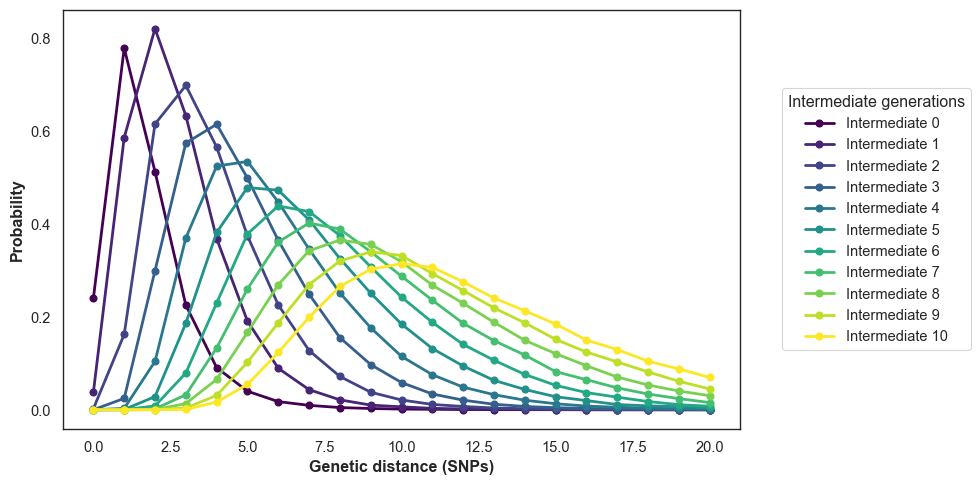

In [32]:
relaxed_genetic_prob = genetic_linkage_probability(
    genetic_distance=np.arange(0, 21, 1),  # 0 to 20 SNPs
    toit=TOIT(
        params=params,
        relax_rate=True
    ),
    kind="raw",
)

plot_intermediate_probabilities(relaxed_genetic_prob)

In [58]:
def plot_probability_grid(
    list_of_prob_arrays,
    titles=None,
    cmap_name="cividis",
    linewidth=2,
    figsize=(12, 8)
):
    """
    list_of_prob_arrays: list of 2D arrays (genetic_distance × intermediates)
    titles: optional list of subplot titles
    """

    n_plots = len(list_of_prob_arrays)
    n_cols = 2
    n_rows = int(np.ceil(n_plots / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True, sharey="row")
    axes = axes.flatten()

    for idx, prob in enumerate(list_of_prob_arrays):
        ax = axes[idx]
        x = np.arange(prob.shape[0])
        n_intermediates = prob.shape[1]

        cmap = plt.get_cmap(cmap_name)
        colours = cmap(np.linspace(0, 1, n_intermediates))

        for i in range(n_intermediates):
            ax.plot(
                x,
                prob[:, i],
                color=colours[i],
                linewidth=linewidth,
                marker="o",
                label=f"Intermediates = {i}",
            )

        if titles:
            ax.set_title(titles[idx], fontweight="bold")

        ax.set_xlabel("Genetic distance (SNPs)")
        ax.set_ylabel("Probability")

    # Put a single legend outside the grid
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Intermediate generations",
        bbox_to_anchor=(1.05, 0.5),
        loc="center left"
    )

    plt.tight_layout()
    plt.show()
    plt.close()

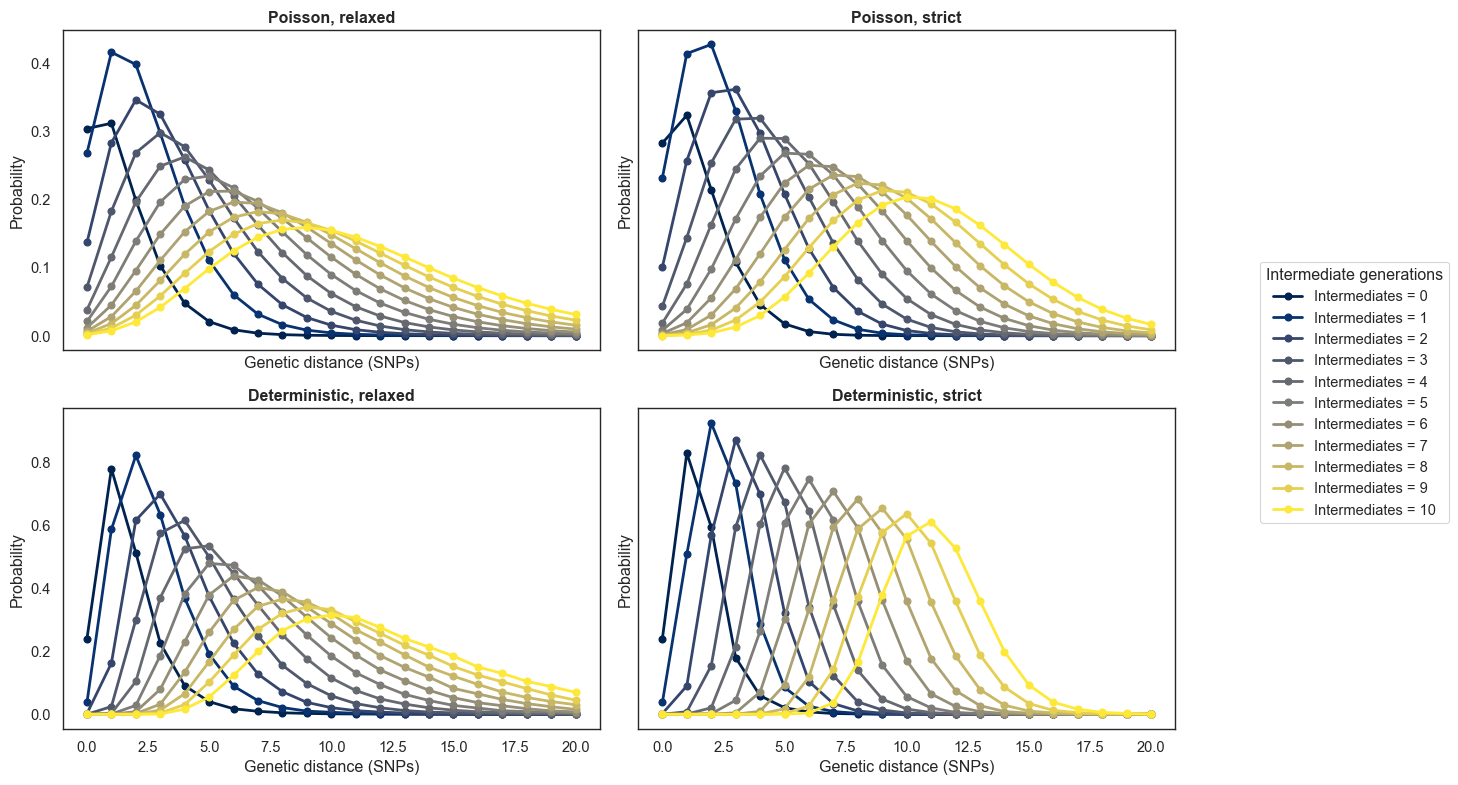

In [59]:
distances = np.arange(0, 21, 1)
kind = "raw"

prob_poisson_relaxed = genetic_linkage_probability(
    distances,
    toit=TOIT(params=params, relax_rate=True, mutation_model="poisson"),
    kind=kind,
)

prob_poisson_strict = genetic_linkage_probability(
    distances,
    toit=TOIT(params=params, relax_rate=False, mutation_model="poisson"),
    kind=kind,
)

prob_deterministic_relaxed = genetic_linkage_probability(
    distances,
    toit=TOIT(params=params, relax_rate=True, mutation_model="deterministic"),
    kind=kind,
)

prob_deterministic_strict = genetic_linkage_probability(
    distances,
    toit=TOIT(params=params, relax_rate=False, mutation_model="deterministic"),
    kind=kind,
)

plot_probability_grid(
    [
        prob_poisson_relaxed,
        prob_poisson_strict,
        prob_deterministic_relaxed,
        prob_deterministic_strict,
    ],
    titles=[
        "Poisson, relaxed",
        "Poisson, strict",
        "Deterministic, relaxed",
        "Deterministic, strict"
    ],
)

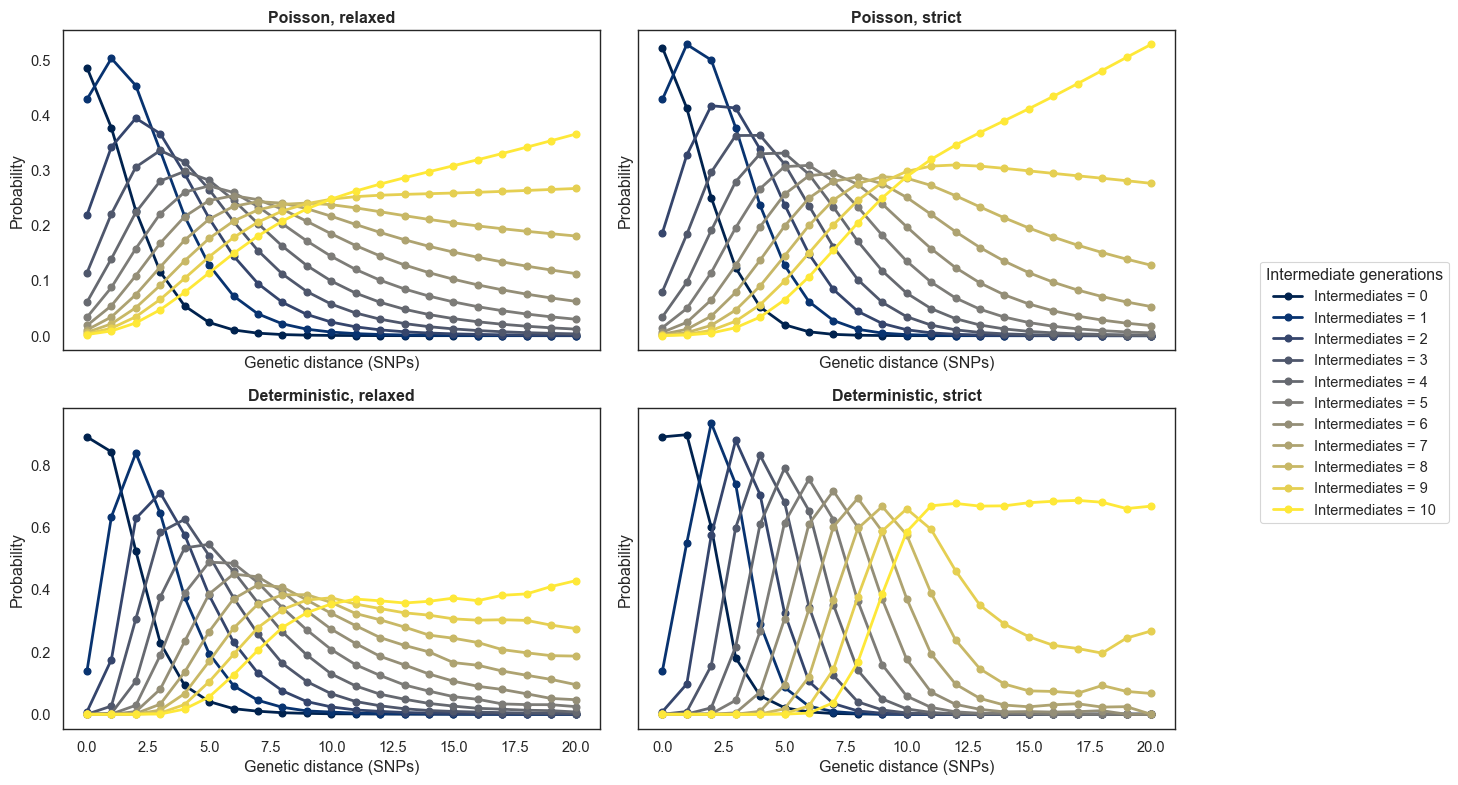

In [60]:
distances = np.arange(0, 21, 1)
kind = "relative"

prob_poisson_relaxed = genetic_linkage_probability(
    distances,
    toit=TOIT(params=params, relax_rate=True, mutation_model="poisson"),
    kind=kind,
)

prob_poisson_strict = genetic_linkage_probability(
    distances,
    toit=TOIT(params=params, relax_rate=False, mutation_model="poisson"),
    kind=kind,
)

prob_deterministic_relaxed = genetic_linkage_probability(
    distances,
    toit=TOIT(params=params, relax_rate=True, mutation_model="deterministic"),
    kind=kind,
)

prob_deterministic_strict = genetic_linkage_probability(
    distances,
    toit=TOIT(params=params, relax_rate=False, mutation_model="deterministic"),
    kind=kind,
)

plot_probability_grid(
    [
        prob_poisson_relaxed,
        prob_poisson_strict,
        prob_deterministic_relaxed,
        prob_deterministic_strict,
    ],
    titles=[
        "Poisson, relaxed",
        "Poisson, strict",
        "Deterministic, relaxed",
        "Deterministic, strict"
    ],
)

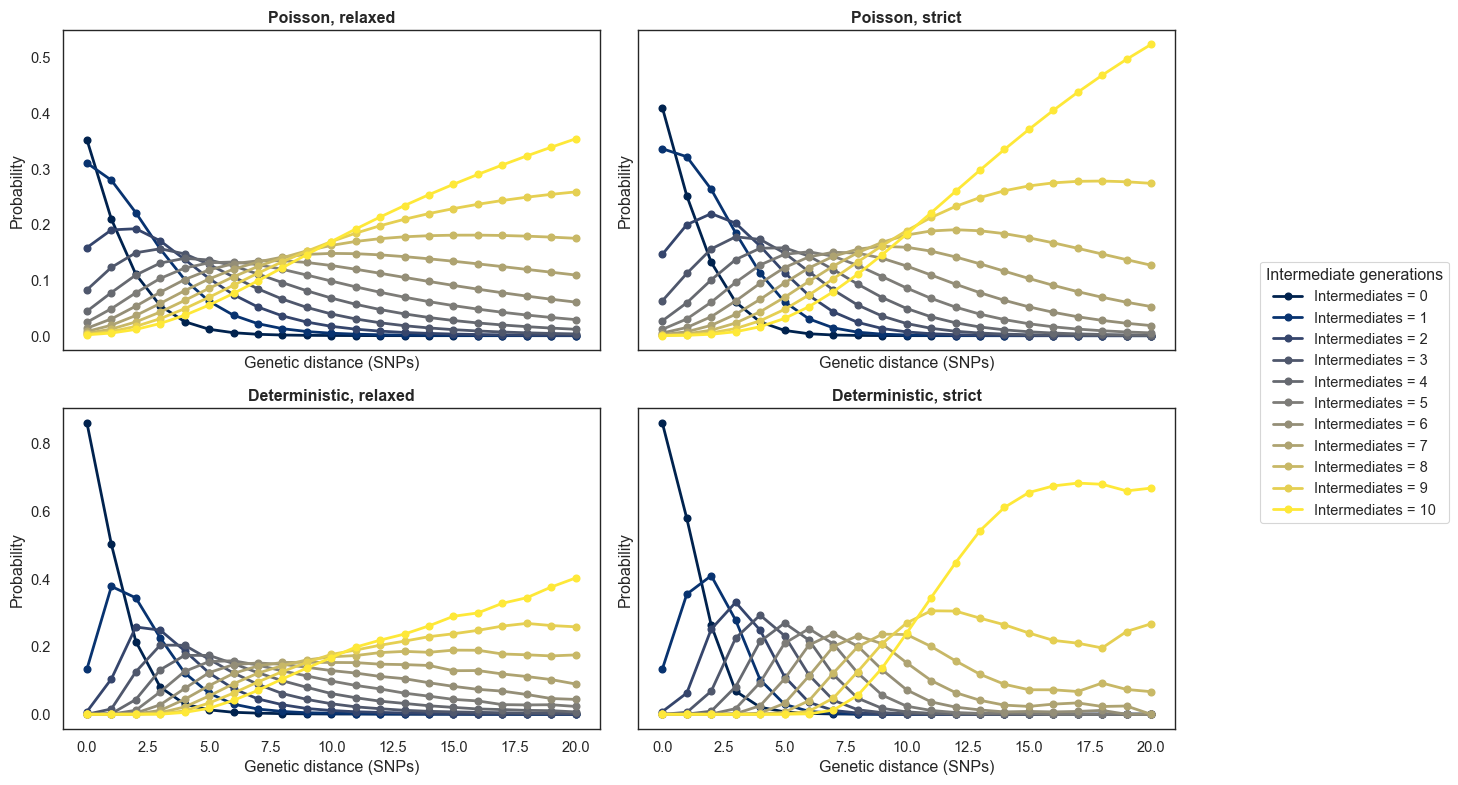

In [61]:
distances = np.arange(0, 21, 1)
kind = "normalized"

prob_poisson_relaxed = genetic_linkage_probability(
    distances,
    toit=TOIT(params=params, relax_rate=True, mutation_model="poisson"),
    kind=kind,
)

prob_poisson_strict = genetic_linkage_probability(
    distances,
    toit=TOIT(params=params, relax_rate=False, mutation_model="poisson"),
    kind=kind,
)

prob_deterministic_relaxed = genetic_linkage_probability(
    distances,
    toit=TOIT(params=params, relax_rate=True, mutation_model="deterministic"),
    kind=kind,
)

prob_deterministic_strict = genetic_linkage_probability(
    distances,
    toit=TOIT(params=params, relax_rate=False, mutation_model="deterministic"),
    kind=kind,
)

plot_probability_grid(
    [
        prob_poisson_relaxed,
        prob_poisson_strict,
        prob_deterministic_relaxed,
        prob_deterministic_strict,
    ],
    titles=[
        "Poisson, relaxed",
        "Poisson, strict",
        "Deterministic, relaxed",
        "Deterministic, strict"
    ],
)

Genetic distance alone cannot faithfully discriminate between different events.

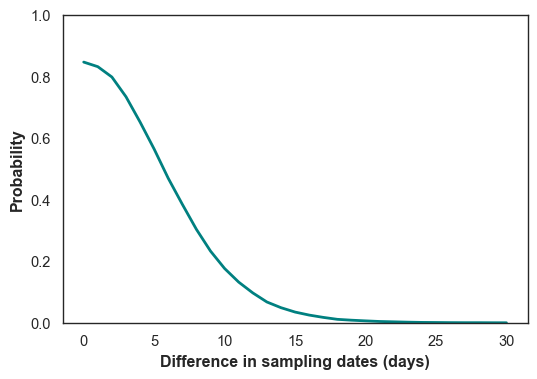

In [7]:
temporal_prob = temporal_linkage_probability(
    temporal_distance=np.arange(0, 31, 1), toit=toit, num_simulations=10000  # 0 to 30 days
)

plt.figure(figsize=(6, 4))
sns.lineplot(x=np.arange(0, 31, 1), y=temporal_prob, color="teal", linewidth=2)
plt.xlabel("Difference in sampling dates (days)", fontweight="bold")
plt.ylabel("Probability", fontweight="bold")
plt.ylim(0, 1)
plt.show()
plt.close()

# Joint probability of recent transmission

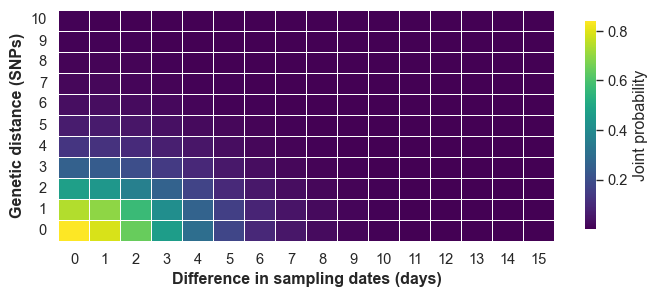

In [8]:
genetic_axis = np.arange(0, 11, 1)  # 0 to 10 SNPs
temporal_axis = np.arange(0, 31, 2)  # 0 to 30 days

prob_matrix = pairwise_linkage_probability_matrix(
    genetic_distances=genetic_axis,
    temporal_distances=temporal_axis,
    intermediate_generations=(0, 1),
    num_simulations=10000,
    relax_rate=True,
)


plt.figure(figsize=(8, 3))
sns.heatmap(
    prob_matrix,
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={"label": "Joint probability", "shrink": 0.9},
)


plt.ylabel("Genetic distance (SNPs)", fontweight="bold")
plt.yticks(rotation=360)
plt.gca().invert_yaxis()
plt.xlabel("Difference in sampling dates (days)", fontweight="bold")
plt.show()
plt.close()

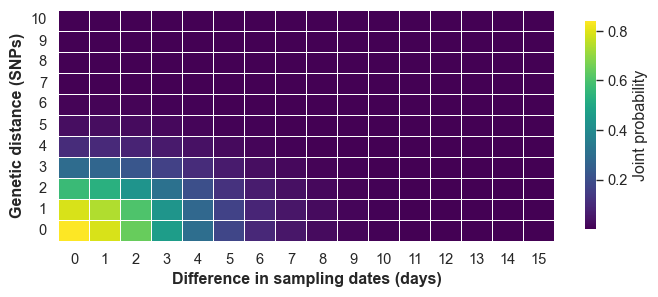

In [9]:
genetic_axis = np.arange(0, 11, 1)  # 0 to 10 SNPs
temporal_axis = np.arange(0, 31, 2)  # 0 to 30 days

prob_matrix = pairwise_linkage_probability_matrix(
    genetic_distances=genetic_axis,
    temporal_distances=temporal_axis,
    intermediate_generations=(0, 1),
    num_simulations=10000,
    relax_rate=False,
)


plt.figure(figsize=(8, 3))
sns.heatmap(
    prob_matrix,
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={"label": "Joint probability", "shrink": 0.9},
)


plt.ylabel("Genetic distance (SNPs)", fontweight="bold")
plt.yticks(rotation=360)
plt.gca().invert_yaxis()
plt.xlabel("Difference in sampling dates (days)", fontweight="bold")
plt.show()
plt.close()